# Coastal change in African countries

* **Products used:** [DE Africa Coastlines]()



## Background

Coastline change can be summarised in country scale to assess trends of change. 

## Description

This notebook adds the country (level 0) and province (level 1) labels to the rate of change points.

## Getting started

To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell.

### Load packages
Import Python packages that are used for the analysis.

In [75]:
import geopandas as gpd
import rioxarray as rxr
import numpy as np
from shapely.ops import nearest_points

from deafrica_tools.spatial import xr_rasterize
from deafrica_tools.coastal import get_coastlines
#from deafrica_tools.plotting import display_map
from datacube.utils.geometry import Geometry

from matplotlib import pyplot as plt
import matplotlib as mpl
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection


## Match coastlines to admin boundaries

In [5]:
%%time

# load coastlines rate of change and filter to keep only good observations

coastlines = gpd.read_file("~/dev/data/deafricacoastlines_v0.4.0.gpkg", layer="rates_of_change")
coastlines = coastlines[(coastlines.certainty=='good')]
coastlines.reset_index(inplace=True)

CPU times: user 2min 49s, sys: 6.38 s, total: 2min 55s
Wall time: 2min 55s


In [6]:
%%time

# load level 1 admin_boundaries

gadm_africa  = gpd.read_file("~/dev/data/gadm_africa.gpkg")
gadm_level0 = gadm_africa.dissolve(by=f"GID_0")
gadm_level0 = gadm_level0.to_crs(coastlines.crs)
gadm_level0.reset_index(inplace=True)

gadm_level1 = gadm_africa.dissolve(by=f"GID_1")
gadm_level1 = gadm_level1.to_crs(coastlines.crs)
gadm_level1.reset_index(inplace=True)

CPU times: user 2min 44s, sys: 216 ms, total: 2min 44s
Wall time: 2min 44s


In [8]:
gadm_level1.columns

Index(['GID_1', 'geometry', 'UID', 'GID_0', 'NAME_0', 'VARNAME_0', 'NAME_1',
       'VARNAME_1', 'NL_NAME_1', 'ISO_1', 'HASC_1', 'CC_1', 'TYPE_1',
       'ENGTYPE_1', 'VALIDFR_1', 'GID_2', 'NAME_2', 'VARNAME_2', 'NL_NAME_2',
       'HASC_2', 'CC_2', 'TYPE_2', 'ENGTYPE_2', 'VALIDFR_2', 'GID_3', 'NAME_3',
       'VARNAME_3', 'NL_NAME_3', 'HASC_3', 'CC_3', 'TYPE_3', 'ENGTYPE_3',
       'VALIDFR_3', 'GID_4', 'NAME_4', 'VARNAME_4', 'CC_4', 'TYPE_4',
       'ENGTYPE_4', 'VALIDFR_4', 'GID_5', 'NAME_5', 'CC_5', 'TYPE_5',
       'ENGTYPE_5', 'GOVERNEDBY', 'SOVEREIGN', 'DISPUTEDBY', 'REGION',
       'VARREGION', 'COUNTRY', 'CONTINENT', 'SUBCONT', 'layer', 'path'],
      dtype='object')

In [ ]:
%%time

# match coastlines to admin region geometries

coastlines = coastlines.sjoin_nearest(gadm_level1[["GID_0", "NAME_0", "GID_1", "NAME_1","geometry"]], how="left", max_distance=1000, distance_col="GID_1_dist")
coastlines = coastlines.drop(columns=["index_right"])
#ind_coast, ind_level =  gadm_level.sindex.nearest(coastlines.geometry, max_distance= 1000, return_all=False, return_distance=False)

In [12]:
coastlines.columns

Index(['index', 'uid', 'rate_time', 'sig_time', 'se_time', 'outl_time',
       'dist_2000', 'dist_2001', 'dist_2002', 'dist_2003', 'dist_2004',
       'dist_2005', 'dist_2006', 'dist_2007', 'dist_2008', 'dist_2009',
       'dist_2010', 'dist_2011', 'dist_2012', 'dist_2013', 'dist_2014',
       'dist_2015', 'dist_2016', 'dist_2017', 'dist_2018', 'dist_2019',
       'dist_2020', 'dist_2021', 'angle_mean', 'angle_std', 'valid_obs',
       'valid_span', 'sce', 'nsm', 'max_year', 'min_year', 'country',
       'certainty', 'geometry', 'GID_0', 'NAME_0', 'GID_1', 'NAME_1'],
      dtype='object')

In [13]:
coastlines.to_file(f"~/dev/data/deafricacoastlines_v0.4.0_nearest_gadm_level1.gpkg")

## Summarise coastline changes for each admin boundaries

Calculate total kms and percentage of coastlines that has expanded or retreated by more than 0.5m per year.

In [183]:
level = 0
gadm_level = gadm_level0

In [172]:
gadm_level[['n_good', 'n_sig99', 'n_pos05', 'n_pos1', 'n_neg05', 'n_neg1']] = [np.nan]*6

In [173]:
for idx in gadm_level.index:
    #print(gadm_level.loc[idx][f"NAME_{level}"])
    
    good_gdf = coastlines[coastlines[f"GID_{level}"]==gadm_level.loc[idx][f"GID_{level}"]]
    if len(good_gdf)==0:
        #print("no data over", gadm_level.loc[idx][f"NAME_{level}"])
        continue

    # get stats
    gadm_level.at[idx, 'n_good'] = len(good_gdf)
    sig_gdf = good_gdf[(good_gdf.sig_time<0.01)]
    gadm_level.at[idx, 'n_sig99'] = len(sig_gdf)
    gadm_level.at[idx, 'n_neg1'] = (sig_gdf.rate_time<=-1).sum()
    gadm_level.at[idx, 'n_neg05'] = (sig_gdf.rate_time<=-0.5).sum()
    gadm_level.at[idx, 'n_pos1'] = (sig_gdf.rate_time>=1).sum()
    gadm_level.at[idx, 'n_pos05'] = (sig_gdf.rate_time>=0.5).sum()
    
gadm_level['perc_neg1']=gadm_level['n_neg1']*100/gadm_level['n_good']
gadm_level['perc_neg05']=gadm_level['n_neg05']*100/gadm_level['n_good']
gadm_level['km_neg1']=gadm_level['n_neg1']*30/1000
gadm_level['km_neg05']=gadm_level['n_neg05']*30/1000

gadm_level['perc_pos1']=gadm_level['n_pos1']*100/gadm_level['n_good']
gadm_level['perc_pos05']=gadm_level['n_pos05']*100/gadm_level['n_good']
gadm_level['km_pos1']=gadm_level['n_pos1']*30/1000
gadm_level['km_pos05']=gadm_level['n_pos05']*30/1000

In [174]:
gadm_level = gadm_level[gadm_level.n_good>0]
gadm_level.to_file(f"~/dev/data/coastlineschange_gadm_level{level}.gpkg")

In [175]:
gadm_level.columns

Index(['GID_1', 'geometry', 'UID', 'GID_0', 'NAME_0', 'VARNAME_0', 'NAME_1',
       'VARNAME_1', 'NL_NAME_1', 'ISO_1', 'HASC_1', 'CC_1', 'TYPE_1',
       'ENGTYPE_1', 'VALIDFR_1', 'GID_2', 'NAME_2', 'VARNAME_2', 'NL_NAME_2',
       'HASC_2', 'CC_2', 'TYPE_2', 'ENGTYPE_2', 'VALIDFR_2', 'GID_3', 'NAME_3',
       'VARNAME_3', 'NL_NAME_3', 'HASC_3', 'CC_3', 'TYPE_3', 'ENGTYPE_3',
       'VALIDFR_3', 'GID_4', 'NAME_4', 'VARNAME_4', 'CC_4', 'TYPE_4',
       'ENGTYPE_4', 'VALIDFR_4', 'GID_5', 'NAME_5', 'CC_5', 'TYPE_5',
       'ENGTYPE_5', 'GOVERNEDBY', 'SOVEREIGN', 'DISPUTEDBY', 'REGION',
       'VARREGION', 'COUNTRY', 'CONTINENT', 'SUBCONT', 'layer', 'path',
       'n_good', 'n_sig99', 'n_pos05', 'n_pos1', 'n_neg05', 'n_neg1',
       'perc_neg1', 'perc_neg05', 'km_neg1', 'km_neg05', 'perc_pos1',
       'perc_pos05', 'km_pos1', 'km_pos05'],
      dtype='object')

## Plot as figures

In [176]:
african_countries  = gpd.read_file("../../Supplementary_data/MGCI/african_countries.geojson")

In [177]:
african_countries.COUNTRY.values

array(['Algeria', 'Angola', 'Benin', 'Botswana', 'Burkina Faso',
       'Burundi', 'Cameroon', 'Cape Verde', 'Central African Republic',
       'Chad', 'Comoros', 'Congo-Brazzaville', 'Cote d`Ivoire',
       'Democratic Republic of Congo', 'Djibouti', 'Egypt',
       'Equatorial Guinea', 'Eritrea', 'Ethiopia', 'Gabon', 'Gambia',
       'Ghana', 'Guinea', 'Guinea-Bissau', 'Kenya', 'Lesotho', 'Liberia',
       'Libya', 'Madagascar', 'Malawi', 'Mali', 'Mauritania', 'Morocco',
       'Mozambique', 'Namibia', 'Niger', 'Nigeria', 'Rwanda',
       'Sao Tome and Principe', 'Senegal', 'Sierra Leone', 'Somalia',
       'South Africa', 'Sudan', 'Swaziland', 'Tanzania', 'Togo',
       'Tunisia', 'Uganda', 'Western Sahara', 'Zambia', 'Zimbabwe'],
      dtype=object)

In [184]:
gid_coastalchange  = gpd.read_file(f"~/dev/data/coastlineschange_gadm_level{level}.gpkg")
gid_coastalchange = gid_coastalchange.fillna(0)
gid_coastalchange = gid_coastalchange.to_crs(african_countries.crs)

4.031864737441066 37.674418604651166
1.2624584717607974 50.36057692307692


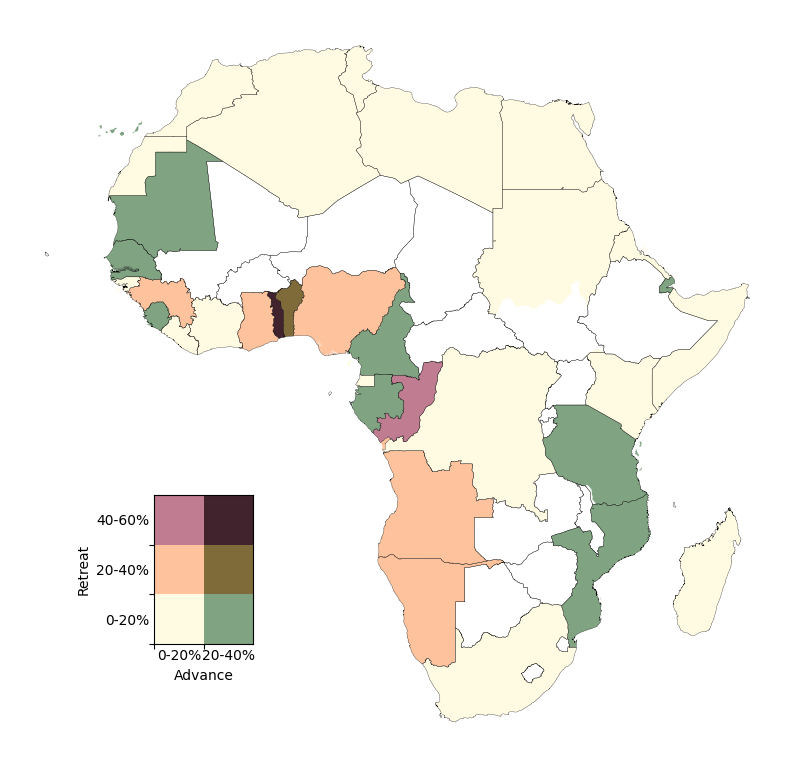

In [196]:
param_2 = 'perc_neg05'
param_1 = 'perc_pos05'

title = 'Percentage of shorelines retreating or advancing at more than 0.5 meter per year'

print(gid_coastalchange[param_1].min(), gid_coastalchange[param_1].max())
print(gid_coastalchange[param_2].min(), gid_coastalchange[param_2].max())

# Define colour map
cmap2 = mpl.cm.YlOrRd #Reds
cmap1 = mpl.cm.PuBuGn #Blues
bounds2 = [0, 20, 40, 60]
bounds1 = [0, 20, 40]

#bounds1 = [0, 25, 50, 75, 100]
#bounds2 = [0, 25, 50, 75, 100]

def bivariate_color(p1, p2, bounds1=bounds1, bounds2=bounds2,
                    cmap1=cmap1, cmap2=cmap2
#                    cmap1=mpl.cm.YlOrRd, cmap2=mpl.cm.PuBuGn
                   ):
    norm1 = mpl.colors.BoundaryNorm(bounds1, cmap1.N)
    norm2 = mpl.colors.BoundaryNorm(bounds2, cmap2.N)

    return np.sum([cmap1(norm1(p1)), cmap2(norm2(p2))], axis=0)/2.


gid_coastalchange['bivariate_color'] = list(bivariate_color(
    gid_coastalchange[param_1], gid_coastalchange[param_2]))

# Define plot and colourbar axes
fig, ax = plt.subplots(1, 1, figsize=(10, 15))

# now create inset legend
cax = ax.inset_axes([0.15, 0.15, 0.2, 0.2])
cax.set_aspect('equal', adjustable='box')
xticks=[]
yticks=[]
for ix in range(len(bounds1)-1):
    lx, hx = bounds1[ix], bounds1[ix+1]
    for iy in range(len(bounds2)-1):
        percentileboxes = [Rectangle((ix, iy), 1, 1)]
        ly, hy = bounds2[iy], bounds2[iy+1]
        pc = PatchCollection(percentileboxes,
                             facecolor=bivariate_color((lx+hx)/2, (ly+hy)/2))
        cax.add_collection(pc)
        if ix==0: yticks.append(f"{ly}-{hy}%")
    xticks.append(f"{lx}-{hx}%")

cax.set_xlim([0, len(bounds1)-1])
cax.set_ylim([0, len(bounds2)-1])
cax.tick_params("both", which="minor", length=0)
cax.set_xticks(np.arange(len(bounds1)-1), "", minor=False)
cax.set_xticks(np.arange(len(bounds1)-1)+0.5, xticks, minor=True)
cax.set_xlabel('Advance')
cax.set_yticks(np.arange(len(bounds2)-1), "", minor=False)
cax.set_yticks(np.arange(len(bounds2)-1)+0.5, yticks, minor=True)
cax.set_ylabel('Retreat')


# Turn off lon-lat ticks and labels
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.set_xticks([])
ax.set_yticks([])

# # Remove frame
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

#gid_coastalchange.plot(param, ax=ax, cmap=cmap, norm=norm);
gid_coastalchange.plot(color=gid_coastalchange['bivariate_color'], ax=ax)
#gid_1_coastalchange.geometry.plot(ax=ax, linewidth=0.2, edgecolor='black', facecolor="none");
#gid_coastalchange.simplify(0.1).geometry.plot(ax=ax, 
#                                               linewidth=0.2, edgecolor='black', facecolor="none");
african_countries.geometry.plot(
    ax=ax, linewidth=0.2, edgecolor='black', facecolor="none")


fig.savefig(f"GID_{level}_{param_1}_{param_2}.png", bbox_inches='tight')

4.031864737441066 37.674418604651166


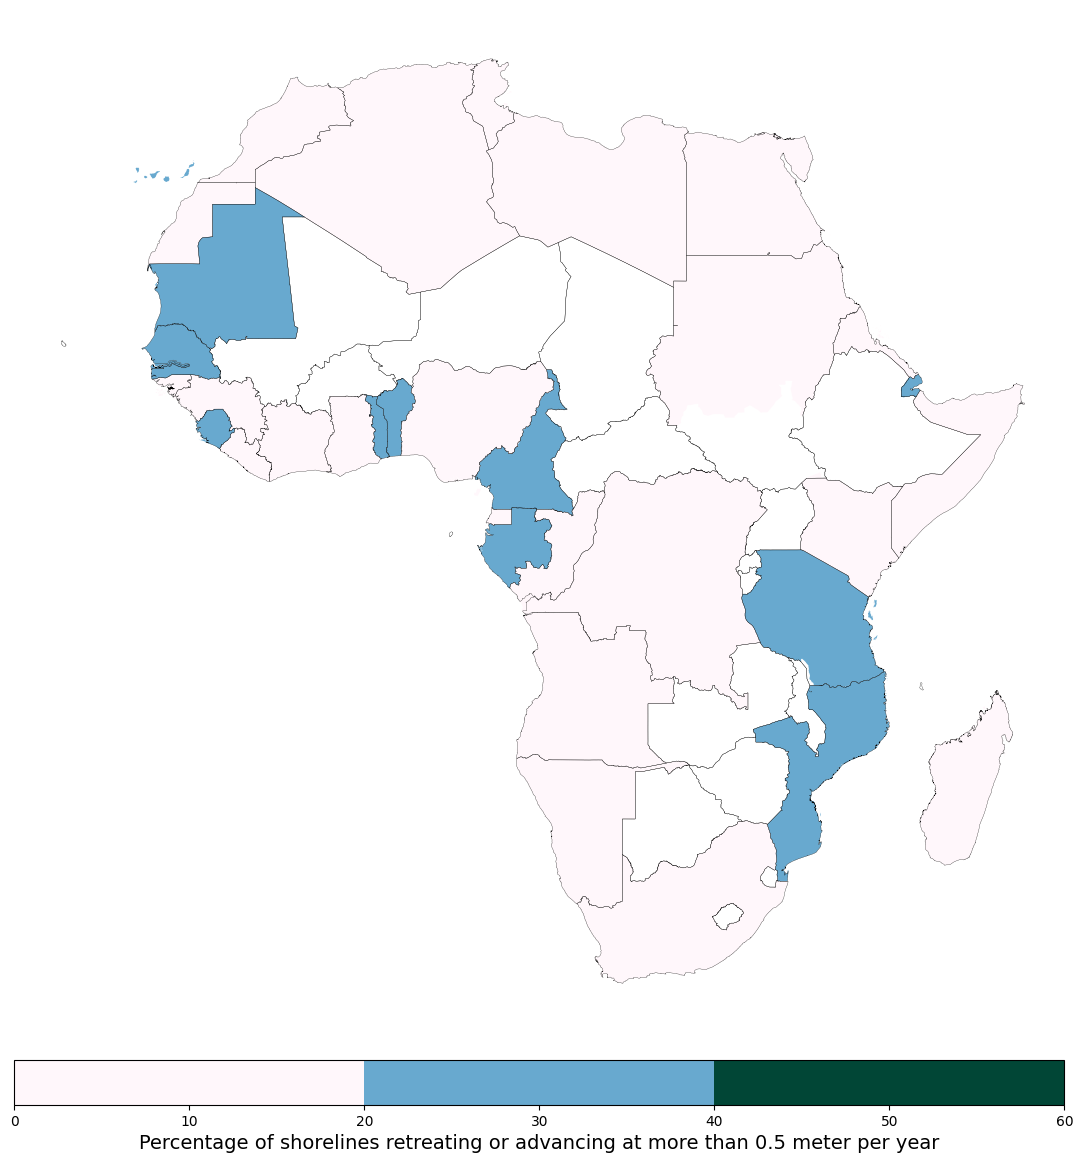

In [190]:
param = 'perc_pos05'
print(gid_coastalchange[param].min(), gid_coastalchange[param].max())

# Define plot and colourbar axes
fig, ax = plt.subplots(1,1, figsize=(15,15))
fig.subplots_adjust(bottom=0.2)
cax = fig.add_axes([0.16, 0.15, 0.70, 0.03])


# Define colour map
cmap = mpl.cm.PuBuGn
bounds = bounds
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)#, extend='both')
cbar = mpl.colorbar.ColorbarBase(cax, cmap=cmap,
                                norm=norm,
                                orientation='horizontal')

# Define colourbar labelling
# cbar.set_ticks([])
cbar.set_ticks([i for i in np.arange(vmin,vmax,steps)])
cbar.set_ticklabels(list('{:.0f}'.format(i) for i in (list(np.arange(vmin, vmax, steps)))))
cbar.set_label(title, fontsize='14')

# Turn off lon-lat ticks and labels
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.set_xticks([])
ax.set_yticks([])

# # Remove frame
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

gid_coastalchange.plot(param, ax=ax, cmap=cmap, norm=norm);
#gid_1_coastalchange.geometry.plot(ax=ax, linewidth=0.2, edgecolor='black', facecolor="none");
#gid_0_coastalchange.simplify(0.05).geometry.plot(ax=ax, linewidth=0.2, edgecolor='black', facecolor="none");
african_countries.geometry.plot(ax=ax, linewidth=0.2, edgecolor='black', facecolor="none");



1.2624584717607974 50.36057692307692


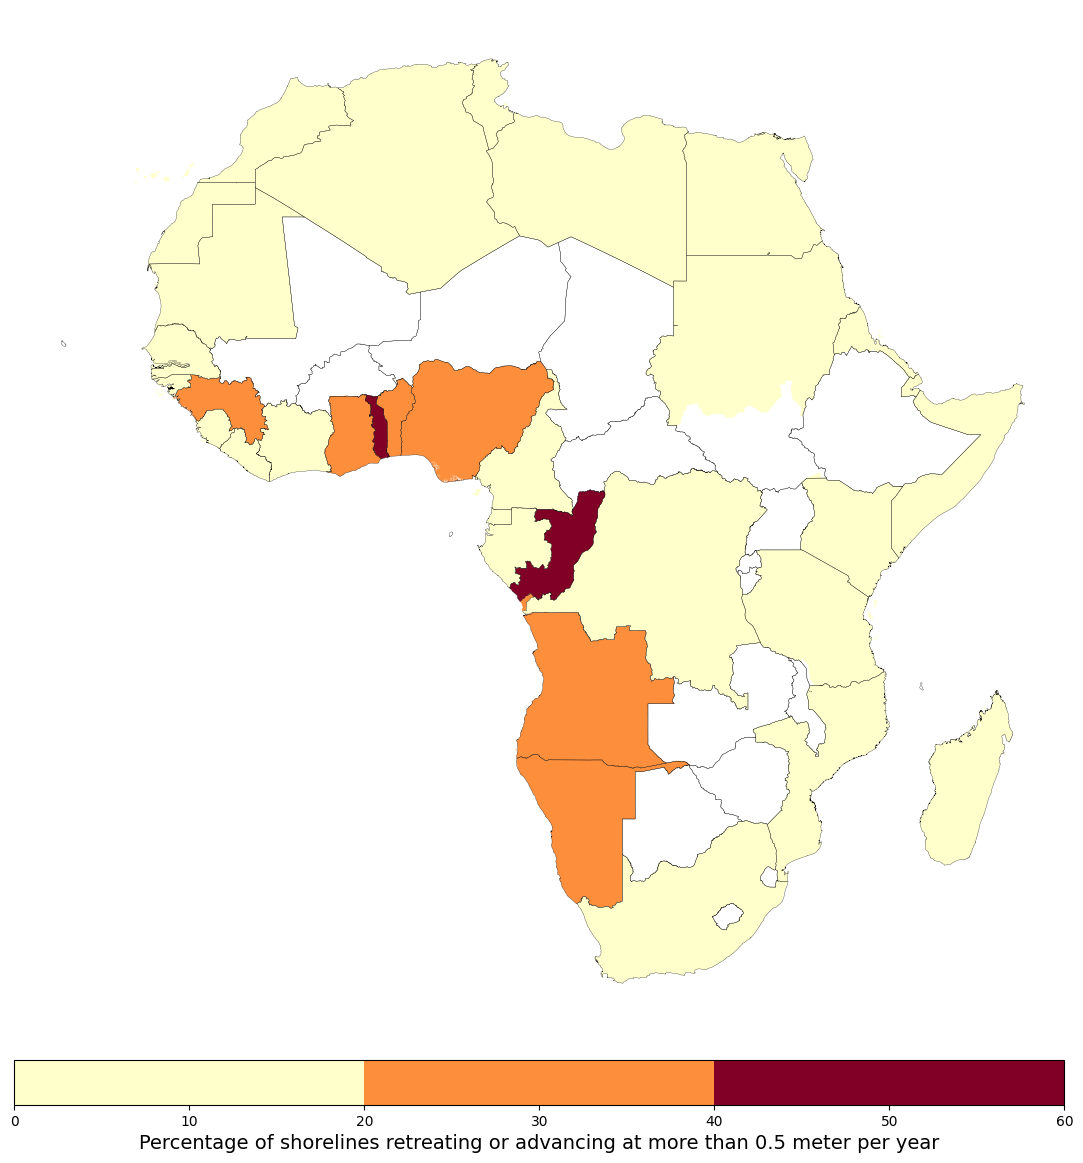

In [165]:
param = 'perc_neg05'
print(gid_coastalchange[param].min(), gid_coastalchange[param].max())

steps = np.ceil((gid_coastalchange[param].max()/10)/10)*10
#vmin, vmax = 0, np.ceil(gid_coastalchange[param].max()/steps)*steps+steps
#print(vmin, vmax)

# Define plot and colourbar axes
fig, ax = plt.subplots(1,1, figsize=(15,15))
fig.subplots_adjust(bottom=0.2)
cax = fig.add_axes([0.16, 0.15, 0.70, 0.03])


# Define colour map
cmap = mpl.cm.YlOrRd
bounds = bounds
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)#, extend='both')
cbar = mpl.colorbar.ColorbarBase(cax, cmap=cmap,
                                norm=norm,
                                orientation='horizontal')

# Define colourbar labelling
# cbar.set_ticks([])
cbar.set_ticks([i for i in np.arange(vmin,vmax,steps)])
cbar.set_ticklabels(list('{:.0f}'.format(i) for i in (list(np.arange(vmin, vmax, steps)))))
cbar.set_label(title, fontsize='14')

# Turn off lon-lat ticks and labels
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.set_xticks([])
ax.set_yticks([])

# # Remove frame
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

gid_coastalchange.plot(param, ax=ax, cmap=cmap, norm=norm);
#gid_1_coastalchange.geometry.plot(ax=ax, linewidth=0.2, edgecolor='black', facecolor="none");
#gid_0_coastalchange.simplify(0.05).geometry.plot(ax=ax, linewidth=0.2, edgecolor='black', facecolor="none");
african_countries.geometry.plot(ax=ax, linewidth=0.2, edgecolor='black', facecolor="none");


0.0 285.15
0 330.0


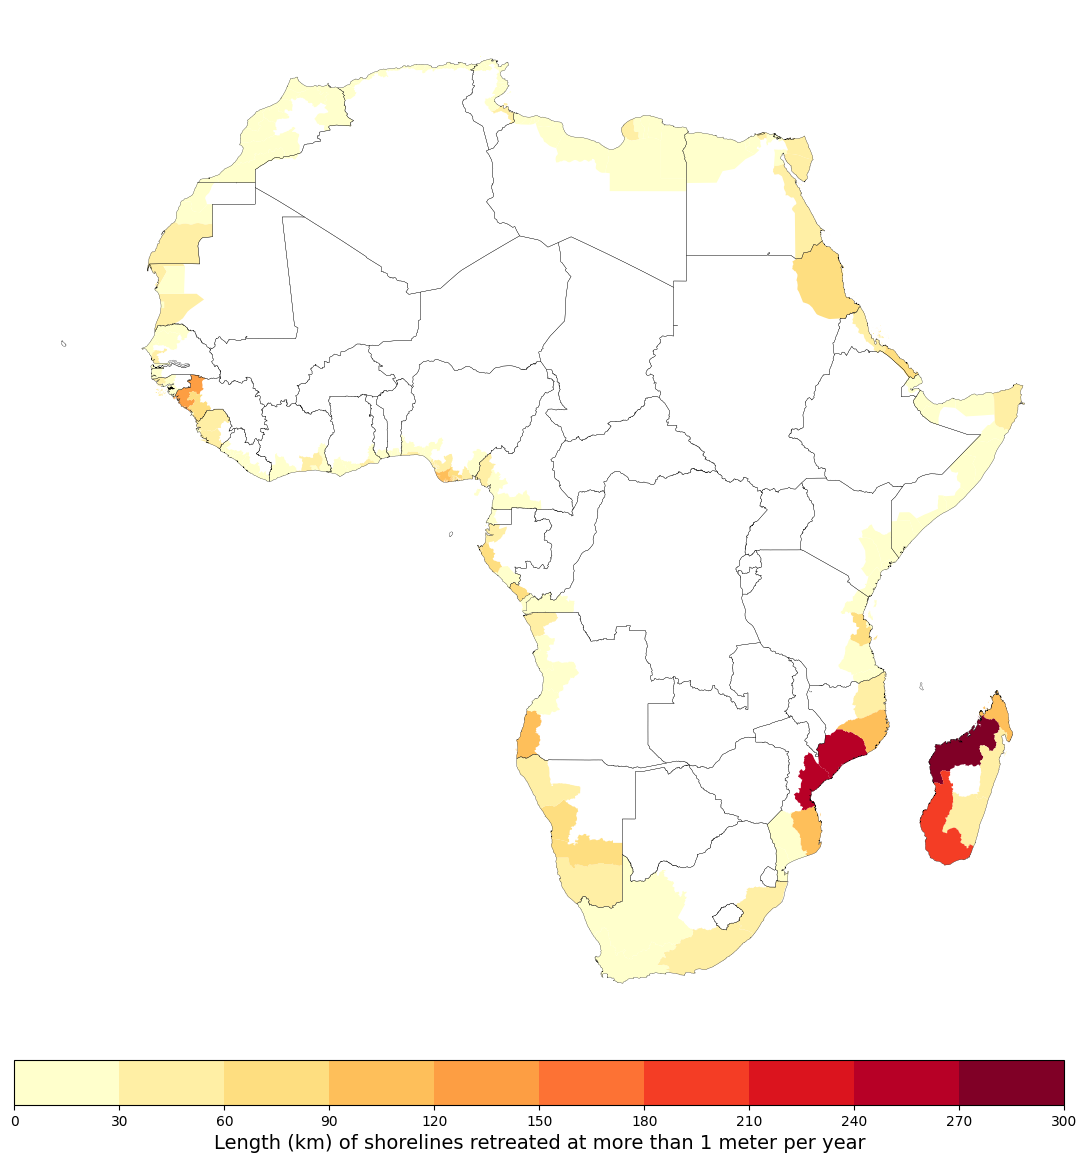

In [44]:
param = 'km_neg1'
title = 'Length (km) of shorelines retreated at more than 1 meter per year'

print(gid_1_coastalchange[param].min(), gid_1_coastalchange[param].max())

steps = np.ceil((gid_1_coastalchange[param].max()/10)/10)*10
vmin, vmax = 0, np.ceil(gid_1_coastalchange[param].max()/steps)*steps+steps
print(vmin, vmax)

# Define plot and colourbar axes
fig, ax = plt.subplots(1,1, figsize=(15,15))
fig.subplots_adjust(bottom=0.2)
cax = fig.add_axes([0.16, 0.15, 0.70, 0.03])


# Define colour map
cmap = mpl.cm.YlOrRd
bounds = list(np.arange(vmin,vmax,steps))
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)#, extend='both')
cbar = mpl.colorbar.ColorbarBase(cax, cmap=cmap,
                                norm=norm,
                                orientation='horizontal')

# Define colourbar labelling
# cbar.set_ticks([])
cbar.set_ticks([i for i in np.arange(vmin,vmax,steps)])
cbar.set_ticklabels(list('{:.0f}'.format(i) for i in (list(np.arange(vmin, vmax, steps)))))
cbar.set_label(title, fontsize='14')

# Turn off lon-lat ticks and labels
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.set_xticks([])
ax.set_yticks([])

# # Remove frame
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

gid_1_coastalchange.plot(param, ax=ax, cmap=cmap, norm=norm);
#gid_1_coastalchange.geometry.plot(ax=ax, linewidth=0.2, edgecolor='black', facecolor="none");
#gid_0_coastalchange.simplify(0.05).geometry.plot(ax=ax, linewidth=0.2, edgecolor='black', facecolor="none");
african_countries.geometry.plot(ax=ax, linewidth=0.2, edgecolor='black', facecolor="none");


fig.savefig(f"GID_{level}_{param}.png", bbox_inches='tight')